# Chapter 10 
 Machine Learning for Business Analytics<br>
Concepts, Techniques, and Applications in Python<br>
by Galit Shmueli, Peter C. Bruce, Peter Gedeck, Nitin R. Patel

Publisher: Wiley; 2nd edition (2024) <br>
<!-- ISBN-13: 978-3031075650 -->

(c) 2024 Galit Shmueli, Peter C. Bruce, Peter Gedeck, Nitin R. Patel

The code needs to be executed in sequence.

Python packages and Python itself change over time. This can cause warnings or errors.
"Warnings" are for information only and can usually be ignored.
"Errors" will stop execution and need to be fixed in order to get results.

If you come across an issue with the code, please follow these steps

- Check the repository (https://gedeck.github.io/sdsa-code-solutions/) to see if the code has been upgraded. This might solve the problem.
- Report the problem using the issue tracker at https://github.com/gedeck/sdsa-code-solutions/issues
- Paste the error message into Google and see if someone else already found a solution

In [2]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from mord import LogisticIT
import matplotlib.pylab as plt
import seaborn as sns
import mlba
%matplotlib inline

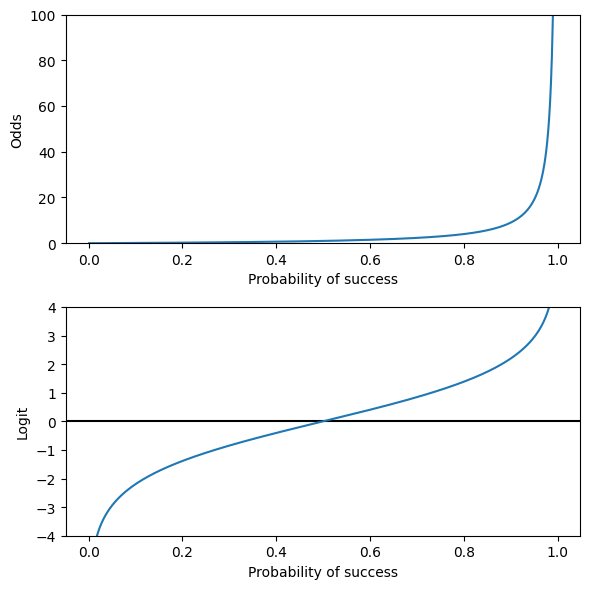

In [3]:
p = np.arange(0.001, 0.999, 0.001)
df = pd.DataFrame({
    'Probability of success': p,
    'Odds': p / (1 - p),
    'Logit': np.log(p / (1 - p))
})
fig, axes = plt.subplots(nrows = 2, figsize = (6, 6))
df.plot(x = 'Probability of success', y = 'Odds', ax = axes[0], ylim = (0, 100))
axes[0].set_ylabel('Odds')
axes[1].axhline(y = 0, color = 'black', linestyle = '-')
df.plot(x = 'Probability of success', y = 'Logit', ax = axes[1], ylim = (-4, 4))
axes[1].set_ylabel('Logit')
for ax in axes:
    ax.legend().set_visible(False)
plt.tight_layout()
plt.show()

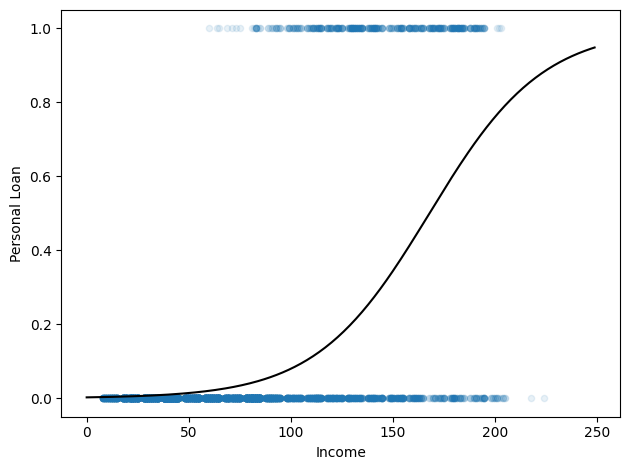

In [4]:
bank_df = mlba.load_data('UniversalBank.csv')

income = np.arange(0, 250, 1)
df = pd.DataFrame({
    'Income': income,
    'p': 1 / (1 + np.exp(6.04892 - 0.036 * income)),
})

ax = bank_df.plot.scatter(x='Income', y='Personal Loan', alpha=0.1)
ax.plot(df['Income'], df['p'], color='black')
plt.tight_layout()
plt.show()

In [5]:
bank_df = mlba.load_data('UniversalBank.csv')
bank_df = bank_df.drop(columns=['ID', 'ZIP Code'])

# Treat education as categorical, convert to dummy variables
bank_df['Education'] = bank_df['Education'].astype('category')
new_categories = {1: 'Undergrad', 2: 'Graduate', 3: 'Advanced/Professional'}
bank_df['Education'] = bank_df.Education.cat.rename_categories(new_categories)
bank_df = pd.get_dummies(bank_df, prefix_sep='_', drop_first=True, dtype=int)

y = bank_df['Personal Loan']
X = bank_df.drop(columns=['Personal Loan'])

# partition data
train_X, holdout_X, train_y, holdout_y = train_test_split(X, y, test_size=0.4, random_state=1)

# fit a logistic regression (set penalty=l2 and C=1e42 to avoid regularization)
logit_reg = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_reg.fit(train_X, train_y)

print(f'Intercept {logit_reg.intercept_[0]:.6f}')
print(pd.DataFrame({'Coeff': logit_reg.coef_[0]}, index=X.columns).transpose())

aic_score = mlba.AIC_score(y_true=holdout_y, y_pred=logit_reg.predict(holdout_X),
                           df=len(train_X.columns)+1)
print(f'AIC {aic_score:.3f}')

Intercept -12.616348
            Age  Experience    Income    Family     CCAvg  Mortgage  \
Coeff -0.032656    0.034264  0.058825  0.614107  0.240529  0.001012   

       Securities Account  CD Account    Online  CreditCard  \
Coeff           -1.026474    3.648572 -0.677954   -0.956315   

       Education_Graduate  Education_Advanced/Professional  
Coeff            4.192255                          4.34193  
AIC -709.152


In [6]:
logit_reg_proba = logit_reg.predict_proba(holdout_X)
logit_result = pd.DataFrame({'actual': holdout_y,
                             'p(0)': [p[0] for p in logit_reg_proba],
                             'p(1)': [p[1] for p in logit_reg_proba],
                             'predicted': logit_reg.predict(holdout_X) })

# display four different cases
interestingCases = [2764, 932, 2721, 702]
print(logit_result.loc[interestingCases])

      actual      p(0)      p(1)  predicted
2764       0  0.976167  0.023833          0
932        0  0.334684  0.665316          1
2721       1  0.031645  0.968355          1
702        1  0.985721  0.014279          0


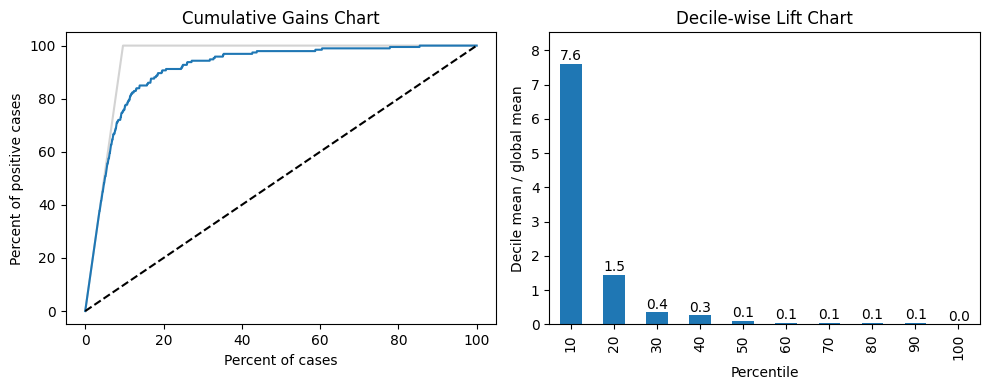

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
mlba.gainsChart(logit_result, ranking='p(1)', actual='actual', ax=axes[0])
mlba.liftChart(logit_result, ranking='p(1)', actual='actual', ax=axes[1])
plt.tight_layout()
plt.show()

In [8]:
data = mlba.load_data('accidentsFull.csv')
outcome = 'MAX_SEV_IR'
predictors = ['ALCHL_I', 'WEATHER_R']

y = data[outcome]
X = data[predictors]
train_X, train_y = X, y

print('Nominal logistic regression')
logit = LogisticRegression(penalty="l2", solver='lbfgs', C=1e24)
logit.fit(X, y)
print(f'  Intercept {logit.intercept_}')
print(f'  Coefficients\n{logit.coef_}')
print()
probs = logit.predict_proba(X)
results = pd.DataFrame({
    'actual': y, 'predicted': logit.predict(X),
    'P(0)': [p[0] for p in probs],
    'P(1)': [p[1] for p in probs],
    'P(2)': [p[2] for p in probs],
})
print(results.head().round(3))
print()

print('Ordinal logistic regression')
logit = LogisticIT(alpha=0)
logit.fit(X, y)
print(f'  Theta {logit.theta_}')
print(f'  Coefficients {logit.coef_}')
print()
probs = logit.predict_proba(X)
results = pd.DataFrame({
    'actual': y, 'predicted': logit.predict(X),
    'P(0)': [p[0] for p in probs],
    'P(1)': [p[1] for p in probs],
    'P(2)': [p[2] for p in probs],
})
print(results.head().round(3))

Nominal logistic regression
  Intercept [-0.17870851  0.81673248 -0.63802397]
  Coefficients
[[ 0.52491466  0.40469045]
 [ 0.15763357  0.16071816]
 [-0.68254823 -0.56540861]]

   actual  predicted   P(0)   P(1)   P(2)
0       1          1  0.491  0.499  0.010
1       0          0  0.554  0.441  0.004
2       0          0  0.554  0.441  0.004
3       0          1  0.491  0.499  0.010
4       0          1  0.394  0.578  0.028

Ordinal logistic regression
  Theta [-1.06916285  2.77444326]
  Coefficients [-0.40112008 -0.25174207]

   actual  predicted   P(0)   P(1)   P(2)
0       1          1  0.496  0.483  0.021
1       0          0  0.559  0.425  0.017
2       0          0  0.559  0.425  0.017
3       0          1  0.496  0.483  0.021
4       0          1  0.397  0.571  0.031


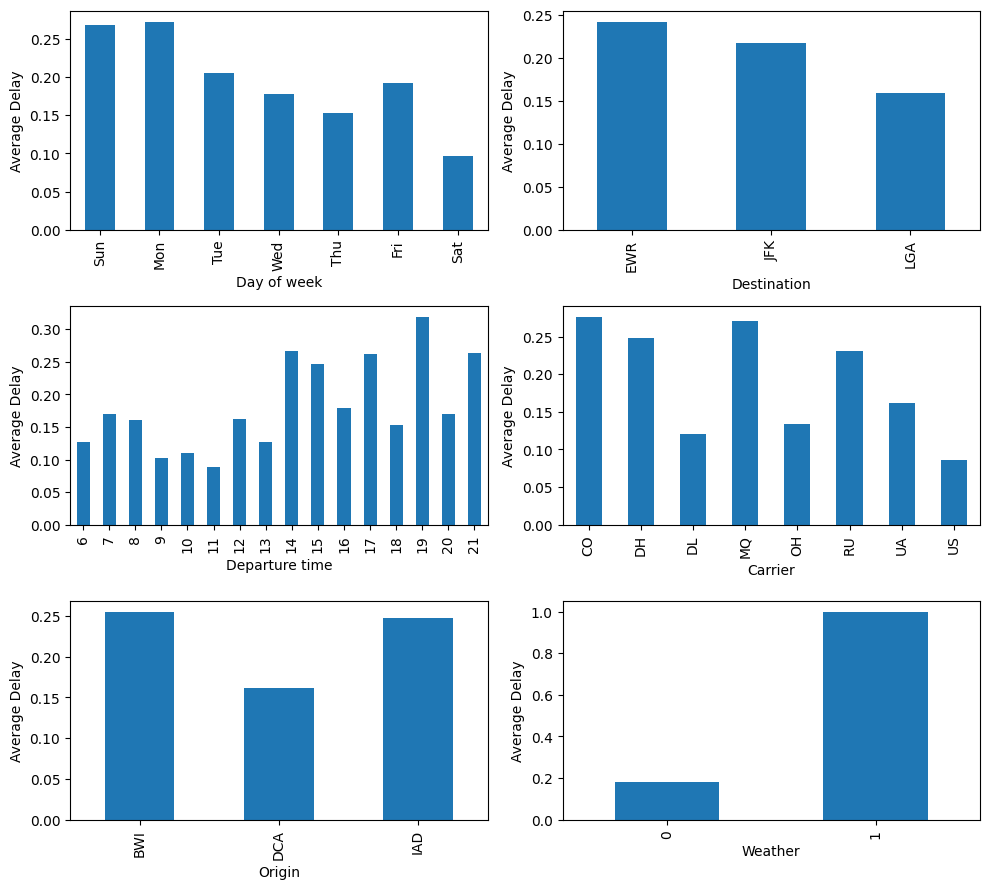

In [9]:
delays_df = mlba.load_data('FlightDelays.csv')
# Create an indicator variable
delays_df['isDelayed'] = [1 if status == 'delayed' else 0
                          for status in delays_df['Flight Status']]

def createGraph(group, xlabel, axis):
    groupAverage = delays_df.groupby([group])['isDelayed'].mean()
    if group == 'DAY_WEEK': # rotate so that display starts on Sunday
        groupAverage = groupAverage.reindex(index=np.roll(groupAverage.index,1))
        groupAverage.index = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
    ax = groupAverage.plot.bar(color='C0', ax=axis)
    ax.set_ylabel('Average Delay')
    ax.set_xlabel(xlabel)
    return ax

def graphDepartureTime(xlabel, axis):
    temp_df = pd.DataFrame({'CRS_DEP_TIME': delays_df['CRS_DEP_TIME'] // 100,
                            'isDelayed': delays_df['isDelayed']})
    groupAverage = temp_df.groupby(['CRS_DEP_TIME'])['isDelayed'].mean()
    ax = groupAverage.plot.bar(color='C0', ax=axis)
    ax.set_xlabel(xlabel); ax.set_ylabel('Average Delay')

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 9))

createGraph('DAY_WEEK', 'Day of week', axis=axes[0][0])
createGraph('DEST', 'Destination', axis=axes[0][1])
graphDepartureTime('Departure time', axis=axes[1][0])
createGraph('CARRIER', 'Carrier', axis=axes[1][1])
createGraph('ORIGIN', 'Origin', axis=axes[2][0])
createGraph('Weather', 'Weather', axis=axes[2][1])
plt.tight_layout()
plt.show()

 
We introduced the column `isDelayed` to be able to easily compute the average delay for each group.

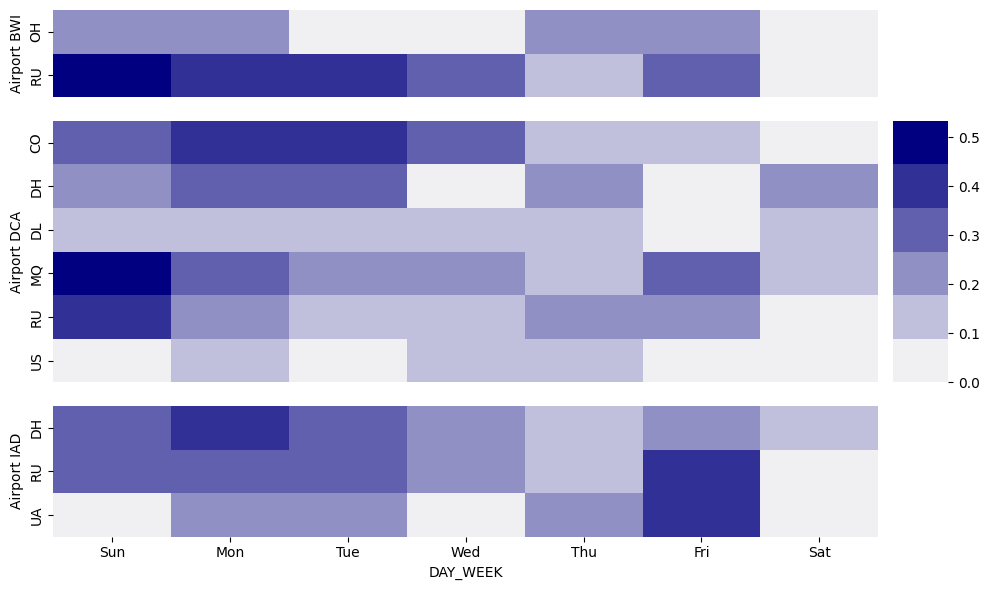

In [10]:
agg = delays_df.groupby(['ORIGIN', 'DAY_WEEK', 'CARRIER']).isDelayed.mean()
agg = agg.reset_index()

# Define the layout of the graph
height_ratios = []
for i, origin in enumerate(sorted(delays_df.ORIGIN.unique())):
    height_ratios.append(len(agg[agg.ORIGIN == origin].CARRIER.unique()))
gridspec_kw = {'height_ratios': height_ratios, 'width_ratios': [15, 1]}
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 6),
                         gridspec_kw = gridspec_kw)
axes[0, 1].axis('off')
axes[2, 1].axis('off')

maxIsDelay = agg.isDelayed.max()
for i, origin in enumerate(sorted(delays_df.ORIGIN.unique())):
    data = pd.pivot_table(agg[agg.ORIGIN == origin], values='isDelayed', aggfunc='sum',
                          index=['CARRIER'], columns=['DAY_WEEK'])
    data = data[[7, 1, 2, 3, 4, 5, 6]]  # Shift last columns to first
    ax = sns.heatmap(data, ax=axes[i][0], vmin=0, vmax=maxIsDelay,
                     cbar_ax=axes[1][1], cmap=sns.light_palette("navy"))
    ax.set_xticklabels(['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])
    if i != 2:
        ax.get_xaxis().set_visible(False)
    ax.set_ylabel('Airport ' + origin)
plt.tight_layout()
plt.show()

In [11]:
delays_df = mlba.load_data('FlightDelays.csv')

# create hourly bins departure time
delays_df['CRS_DEP_TIME'] = [round(t / 100) for t in delays_df['CRS_DEP_TIME']]

# convert to categorical
delays_df['DAY_WEEK'] = delays_df['DAY_WEEK'].astype('category')
delays_df['CRS_DEP_TIME'] = delays_df['CRS_DEP_TIME'].astype('category')
delays_df['Flight Status'] = delays_df['Flight Status'].astype('category')
new_categories = {'ontime': '0-ontime', 'delayed': '1-delayed'}
delays_df['Flight Status'] = delays_df['Flight Status'].cat.rename_categories(new_categories)

predictors = ['DAY_WEEK', 'CRS_DEP_TIME', 'ORIGIN', 'DEST', 'CARRIER', 'Weather']
outcome = 'Flight Status'

X = pd.get_dummies(delays_df[predictors], drop_first=True)
y = delays_df[outcome]

# split into training and validation
train_X, holdout_X, train_y, holdout_y = train_test_split(X, y, test_size=0.4, random_state=1)

logit_full = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_full.fit(train_X, train_y)

print(f'Intercept {logit_full.intercept_[0]:.5f}')
with pd.option_context('display.max_columns', None):
    print(pd.DataFrame({'Coeff': logit_full.coef_[0]},
        index=X.columns).transpose().round(3))

aic_score = mlba.AIC_score(y_true=holdout_y, y_pred=logit_full.predict(holdout_X), df=len(train_X.columns) + 1)
print(f'AIC {aic_score:.3f}')

Intercept -1.21910
       Weather  DAY_WEEK_2  DAY_WEEK_3  DAY_WEEK_4  DAY_WEEK_5  DAY_WEEK_6  \
Coeff    9.325      -0.598      -0.705      -0.799      -0.296      -1.129   

       DAY_WEEK_7  CRS_DEP_TIME_7  CRS_DEP_TIME_8  CRS_DEP_TIME_9  \
Coeff      -0.135           0.631           0.382          -0.365   

       CRS_DEP_TIME_10  CRS_DEP_TIME_11  CRS_DEP_TIME_12  CRS_DEP_TIME_13  \
Coeff            0.337            0.078            0.399            0.175   

       CRS_DEP_TIME_14  CRS_DEP_TIME_15  CRS_DEP_TIME_16  CRS_DEP_TIME_17  \
Coeff            0.202            1.265            0.628            1.093   

       CRS_DEP_TIME_18  CRS_DEP_TIME_19  CRS_DEP_TIME_20  CRS_DEP_TIME_21  \
Coeff            0.285            1.655            1.023            1.077   

       ORIGIN_DCA  ORIGIN_IAD  DEST_JFK  DEST_LGA  CARRIER_DH  CARRIER_DL  \
Coeff       -0.01      -0.134    -0.524    -0.546       0.352      -0.685   

       CARRIER_MQ  CARRIER_OH  CARRIER_RU  CARRIER_UA  CARRIER_US

 
By renaming the categories of `Flight Status`, we make sure that the event of interest (delayed) is coded as the second category.

 Partial output

Confusion Matrix (Accuracy 0.8309)

          Prediction
   Actual  0-ontime 1-delayed
 0-ontime       705         9
1-delayed       140        27


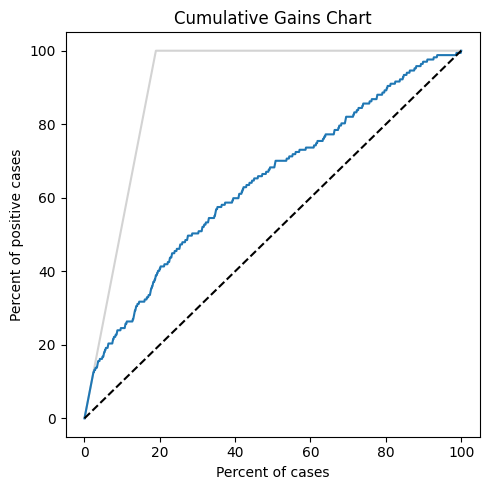

In [12]:
logit_reg_pred = logit_full.predict_proba(holdout_X)
full_result = pd.DataFrame({'actual': holdout_y,
                            'p(0)': [p[0] for p in logit_reg_pred],
                            'p(1)': [p[1] for p in logit_reg_pred],
                            'predicted': logit_full.predict(holdout_X)})

# confusion matrix
mlba.classificationSummary(y_true=full_result['actual'], y_pred=full_result['predicted'])

mlba.gainsChart(full_result, ranking='p(1)', actual='actual', event_level='1-delayed',
                figsize=[5, 5])
plt.tight_layout()
plt.show()

In [13]:
delays_red_df = pd.DataFrame({
    'Sun_Mon' : [1 if d in (1, 7) else 0 for d in delays_df['DAY_WEEK']],
    'Weather' : delays_df['Weather'],
    'CARRIER_CO_MQ_DH_RU' : [1 if d in ("CO", "MQ", "DH", "RU") else 0
                             for d in delays_df['CARRIER']],
    'MORNING' : [1 if d in (6, 7, 8, 9) else 0 for d in delays_df['CRS_DEP_TIME']],
    'NOON' : [1 if d in (10, 11, 12, 13) else 0 for d in delays_df['CRS_DEP_TIME']],
    'AFTER2P' : [1 if d in (14, 15, 16, 17, 18) else 0 for d in delays_df['CRS_DEP_TIME']],
    'EVENING' : [1 if d in (19, 20) else 0 for d in delays_df['CRS_DEP_TIME']],
    'Flight Status': delays_df['Flight Status'],
})

X = delays_red_df.drop(columns=['Flight Status'])
y = delays_red_df['Flight Status']

# split into training and validation
train_X, holdout_X, train_y, holdout_y = train_test_split(X, y, test_size=0.4,
                                                      random_state=1)

logit_red = LogisticRegression(penalty="l2", solver='liblinear', C=1e24)
logit_red.fit(train_X, train_y)

print(f'Intercept {logit_red.intercept_[0]:.5f}')
with pd.option_context('display.max_columns', None):
    print(pd.DataFrame({'coeff': logit_red.coef_[0]},
        index=X.columns).transpose().round(3))

aic_score = mlba.AIC_score(y_true=holdout_y, y_pred=logit_red.predict(holdout_X),
                           df=len(train_X.columns) + 1)
print(f'AIC {aic_score:.3f}')

# confusion matrix
mlba.classificationSummary(y_true=holdout_y, y_pred=logit_red.predict(holdout_X))

Intercept -2.29394
       Sun_Mon  Weather  CARRIER_CO_MQ_DH_RU  MORNING   NOON  AFTER2P  EVENING
coeff     0.59    9.828                1.326   -0.614 -0.698    -0.08    0.568


AIC 934.615
Confusion Matrix (Accuracy 0.8343)

          Prediction
   Actual  0-ontime 1-delayed
 0-ontime       711         3
1-delayed       143        24


 Modified output

In [14]:
predictors = ['DAY_WEEK', 'CRS_DEP_TIME', 'ORIGIN', 'DEST', 'CARRIER', 'Weather']
outcome = 'Flight Status'

X = pd.get_dummies(delays_df[predictors], drop_first=True)
y = delays_df['Flight Status']

# split into training and validation
train_X, l1_holdout_X, train_y, l1_holdout_y = train_test_split(X, y, test_size=0.4,
                                                      random_state=1)

logit_l1 = LogisticRegressionCV(penalty="l1", solver='liblinear', cv=5)
logit_l1.fit(train_X, train_y)

print(f'Intercept {logit_l1.intercept_[0]:.5f}')
with pd.option_context('display.max_columns', None):
    print(pd.DataFrame({'coeff': logit_l1.coef_[0]}, index=X.columns).transpose().round(3))

aic_score = mlba.AIC_score(y_true=holdout_y, y_pred=logit_l1.predict(l1_holdout_X),
                           df=len(train_X.columns) + 1)
print(f'AIC {aic_score:.3f}')

# confusion matrix
mlba.classificationSummary(y_true=holdout_y, y_pred=logit_l1.predict(l1_holdout_X))

Intercept -1.14895
       Weather  DAY_WEEK_2  DAY_WEEK_3  DAY_WEEK_4  DAY_WEEK_5  DAY_WEEK_6  \
coeff    2.321      -0.168      -0.334      -0.456         0.0      -0.725   

       DAY_WEEK_7  CRS_DEP_TIME_7  CRS_DEP_TIME_8  CRS_DEP_TIME_9  \
coeff       0.036             0.0             0.0          -0.263   

       CRS_DEP_TIME_10  CRS_DEP_TIME_11  CRS_DEP_TIME_12  CRS_DEP_TIME_13  \
coeff              0.0              0.0              0.0           -0.029   

       CRS_DEP_TIME_14  CRS_DEP_TIME_15  CRS_DEP_TIME_16  CRS_DEP_TIME_17  \
coeff              0.0            0.582              0.0            0.475   

       CRS_DEP_TIME_18  CRS_DEP_TIME_19  CRS_DEP_TIME_20  CRS_DEP_TIME_21  \
coeff              0.0            0.939              0.0            0.413   

       ORIGIN_DCA  ORIGIN_IAD  DEST_JFK  DEST_LGA  CARRIER_DH  CARRIER_DL  \
coeff      -0.011         0.0    -0.113    -0.205       0.101        -0.7   

       CARRIER_MQ  CARRIER_OH  CARRIER_RU  CARRIER_UA  CARRIER_US

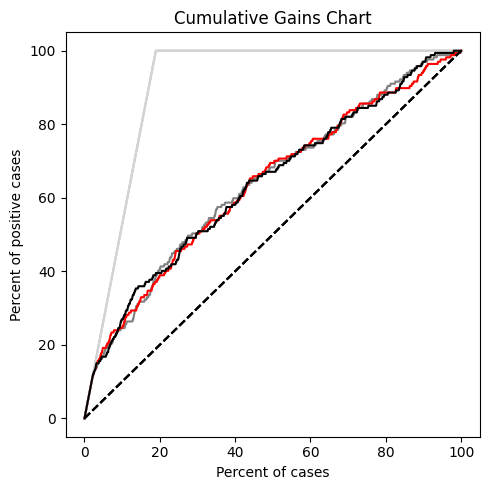

In [15]:
red_result = pd.DataFrame({'actual': holdout_y,
        'p(1)': [p[1] for p in logit_red.predict_proba(holdout_X)]})
l1_result = pd.DataFrame({'actual': holdout_y,
        'p(1)': [p[1] for p in logit_l1.predict_proba(l1_holdout_X)]})

ax = mlba.gainsChart(full_result, ranking='p(1)', actual='actual',
        event_level='1-delayed', label='Full model', color='grey', figsize=[5, 5])
mlba.gainsChart(l1_result, ranking='p(1)', actual='actual',
        event_level='1-delayed', label='Lasso model', color='red', ax=ax)
mlba.gainsChart(red_result, ranking='p(1)', actual='actual',
        event_level='1-delayed', label='Reduced model', color='black', ax=ax)
plt.tight_layout()
plt.show()

In [16]:
# same initial preprocessing and creating dummies

# add constant column
bank_df = sm.add_constant(bank_df, prepend=True)

y = bank_df['Personal Loan']
X = bank_df.drop(columns=['Personal Loan'])

# partition data
train_X, holdout_X, train_y, holdout_y = train_test_split(X, y, test_size=0.4, random_state=1)

# use GLM (general linear model) with the binomial family to fit a logistic regression
logit_reg = sm.GLM(train_y, train_X, family=sm.families.Binomial())
logit_result = logit_reg.fit()
logit_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:          Personal Loan   No. Observations:                 3000
Model:                            GLM   Df Residuals:                     2987
Model Family:                Binomial   Df Model:                           12
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -340.15
Date:                Tue, 29 Oct 2024   Deviance:                       680.30
Time:                        08:27:55   Pearson chi2:                 8.10e+03
No. Iterations:                     8   Pseudo R-squ. (CS):             0.3325
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                             -12.5634      2.336     -5.377      0.000     -17.143      -7.984
Age                                -0.0354      0.086     -0.412      0.680      -0.204       0.133
Experience                          0.0369      0.086      0.431      0.666      -0.131       0.205
Income                              0.0589      0.004     15.044      0.000       0.051       0.067
Family                              0.6128      0.103      5.931      0.000       0.410       0.815
CCAvg                               0.2408      0.060      4.032      0.000       0.124       0.358
Mortgage                            0.0010      0.001      1.301      0.193      -0.001       0.003
Securities Account                 -1.0305      0.422     -2.443      0.015      -1.857      -0.204
CD Account                          3.6628      0.460      7.961      0.000       2.761       4.565
Online                             -0.6794      0.216     -3.140      0.002      -1.103      -0.255
CreditCard                         -0.9609      0.274     -3.507      0.000      -1.498      -0.424
Education_Graduate                  4.2075      0.364     11.573      0.000       3.495       4.920
Education_Advanced/Professional     4.3580      0.365     11.937      0.000       3.642       5.074
===================================================================================================
"""